In [7]:
from math import sqrt

import pandas as pd
import torch
from hydra import compose, initialize
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset

from models import ImputationModel
from saibr_train import load_dataset
from train import train

with initialize(config_path='./configs', version_base='1.3.2'):
    config = compose(config_name='bid_rnn')

In [3]:
train_set, val_set = load_dataset(config)
del train_set
val_loader = DataLoader(val_set, **config.dataloader.val)

In [33]:
model = ImputationModel(**config.model).to(4)
model.load_state_dict(torch.load('checkpoints/ETTm1/saibr_epoch66.pth'))
model = model.eval()

In [44]:
get_val_loss = nn.MSELoss(reduction='sum')

In [61]:
@torch.no_grad()
def validate():
    val_loss = 0
    val_mae = 0

    for batch in val_loader:
        batch: dict[str, Tensor]
        x = batch['x'].to(4)
        mask = batch['mask'].to(4)
        output: Tensor = model.get_output(x, mask)

        output = output[mask]
        x = x[mask]

        loss = get_val_loss(output, x) / mask.sum() * mask.size(0)
        mae = (output-x).abs().sum() / mask.sum() * mask.size(0)
        
        loss = loss.item()
        mae = mae.item()

        # output[~mask] = x[~mask]

        # loss = (output-x).pow(2).sum(dim=1) / mask.sum(dim=1)
        # mae = (output-x).abs().sum(dim=1) / mask.sum(dim=1)

        # loss = loss.sum().item()
        # mae = mae.sum().item()

        val_loss += loss
        val_mae += mae
    
    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)

    return val_loss, val_mae

In [62]:
loss, mae = validate()

In [125]:
with torch.no_grad():
    batch: dict[str, Tensor]
    
    x: Tensor = batch['x'][[0]].to(4)
    mask = batch['mask'][[0]].to(4)

    output = model.get_output(x, mask)
    output[~mask] = x[~mask]

    x = x.squeeze().cpu().numpy()
    output = output.squeeze().cpu().numpy()
    mask_index = torch.nonzero(mask[0, :, 0]).squeeze().cpu().numpy()

In [142]:
output_sliced = output[mask[0, :, 0].cpu().numpy()]
output_replaced = output.copy()
output_replaced[~mask_index] = x[~mask_index]

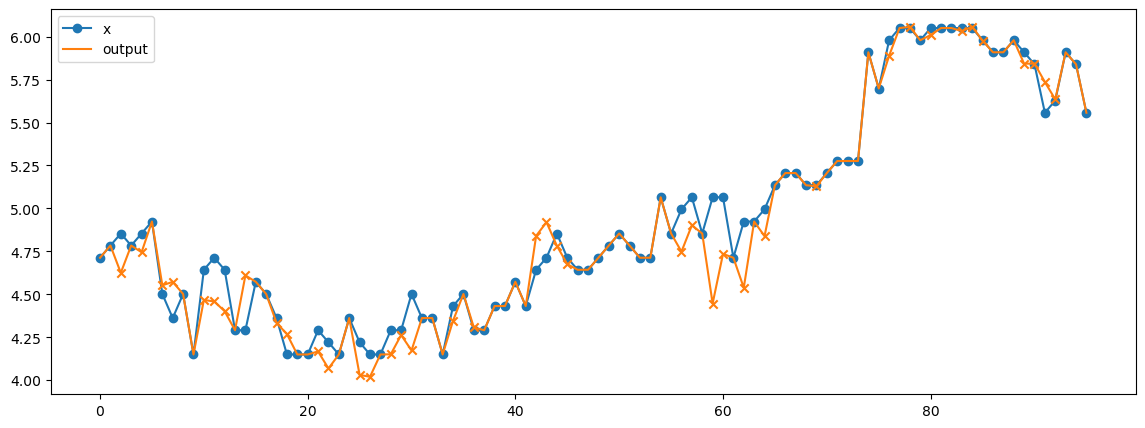

In [148]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(14, 5))
ax.plot(x, label='x', marker='o', zorder=1)
ax.plot(output, label='output', color='tab:orange', zorder=2)
ax.scatter(mask_index, output_sliced, marker='x', color='tab:orange', zorder=2)
ax.legend()